# Phase 6: Anomaly Detection

**Project**: Steel Plates Fault Detection  
**Purpose**: Identify unusual patterns in steel plate faults  
**Date**: December 2024

---

## Overview

Anomaly detection identifies data points that deviate significantly from the norm.

**Algorithm covered:**
- **Isolation Forest**: Tree-based anomaly detection

---

## Why Anomaly Detection?

- 🔍 **Quality control**: Find defective products
- 🛡️ **Fraud detection**: Identify suspicious transactions
- 🏭 **Manufacturing**: Detect equipment failures
- 📊 **Data cleaning**: Find unusual data points

---

## Table of Contents

1. [Setup and Data Loading](#1-setup-and-data-loading)
2. [Isolation Forest](#2-isolation-forest)
3. [Analyze Anomalies](#3-analyze-anomalies)
4. [Visualization](#4-visualization)
5. [Summary](#5-summary)

---
## 1. Setup and Data Loading

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Anomaly detection
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [2]:
# Load and prepare data
df = pd.read_csv('../data/raw/steel_plates_fault.csv')

# Get features
feature_cols = [col for col in df.columns if col != 'Class']
X = df[feature_cols].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

print(f"✓ Data loaded: {X_scaled.shape[0]} samples, {X_scaled.shape[1]} features")

✓ Data loaded: 1941 samples, 27 features


---
## 2. Isolation Forest

### How Isolation Forest Works:

**Key insight:** Anomalies are easier to isolate than normal points.

1. Build random trees by randomly selecting features and split values
2. Anomalies require fewer splits to isolate (shorter path)
3. Normal points require more splits (longer path)
4. Anomaly score based on average path length

**Parameters:**
- `contamination`: Expected proportion of anomalies (e.g., 0.1 = 10%)
- `n_estimators`: Number of trees (default: 100)

**Pros:** Fast, scales well, handles high dimensions  
**Cons:** Assumes anomalies are few and different

In [3]:
# Apply Isolation Forest with different contamination levels
print("🔍 Applying Isolation Forest...\n")

contamination_levels = [0.05, 0.10, 0.15]
results = []

for cont in contamination_levels:
    iso_forest = IsolationForest(contamination=cont, random_state=42, n_estimators=100)
    predictions = iso_forest.fit_predict(X_scaled)
    
    # -1 = anomaly, 1 = normal
    n_anomalies = (predictions == -1).sum()
    n_normal = (predictions == 1).sum()
    
    results.append({
        'contamination': f"{cont*100:.0f}%",
        'anomalies': n_anomalies,
        'normal': n_normal,
        'anomaly_pct': f"{n_anomalies/len(predictions)*100:.1f}%"
    })
    
    print(f"   contamination={cont}: {n_anomalies} anomalies ({n_anomalies/len(predictions)*100:.1f}%)")

print("\n📊 Results:")
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

🔍 Applying Isolation Forest...

   contamination=0.05: 97 anomalies (5.0%)
   contamination=0.1: 194 anomalies (10.0%)
   contamination=0.15: 291 anomalies (15.0%)

📊 Results:
contamination  anomalies  normal anomaly_pct
           5%         97    1844        5.0%
          10%        194    1747       10.0%
          15%        291    1650       15.0%


In [4]:
# Apply with chosen contamination (10%)
contamination = 0.10

iso_forest = IsolationForest(contamination=contamination, random_state=42, n_estimators=100)
anomaly_labels = iso_forest.fit_predict(X_scaled)
anomaly_scores = iso_forest.decision_function(X_scaled)

# Add to dataframe
df['Anomaly'] = anomaly_labels
df['Anomaly_Score'] = anomaly_scores

# Count results
n_anomalies = (anomaly_labels == -1).sum()
n_normal = (anomaly_labels == 1).sum()

print(f"✓ Isolation Forest completed (contamination={contamination})")
print(f"\n📊 Results:")
print(f"   Normal samples:  {n_normal:,} ({n_normal/len(anomaly_labels)*100:.1f}%)")
print(f"   Anomalies:       {n_anomalies:,} ({n_anomalies/len(anomaly_labels)*100:.1f}%)")

print(f"\n📊 Anomaly Score Statistics:")
print(f"   Min (most anomalous): {anomaly_scores.min():.4f}")
print(f"   Max (most normal):    {anomaly_scores.max():.4f}")
print(f"   Mean:                 {anomaly_scores.mean():.4f}")

✓ Isolation Forest completed (contamination=0.1)

📊 Results:
   Normal samples:  1,747 (90.0%)
   Anomalies:       194 (10.0%)

📊 Anomaly Score Statistics:
   Min (most anomalous): -0.1798
   Max (most normal):    0.1139
   Mean:                 0.0487


---
## 3. Analyze Anomalies

In [5]:
# Analyze anomalies by fault type
print("📊 Anomalies by Fault Type:\n")

anomaly_by_class = df.groupby('Class')['Anomaly'].apply(lambda x: (x == -1).sum())
total_by_class = df.groupby('Class').size()
pct_by_class = (anomaly_by_class / total_by_class * 100).round(2)

analysis = pd.DataFrame({
    'Fault Type': anomaly_by_class.index,
    'Total': total_by_class.values,
    'Anomalies': anomaly_by_class.values,
    'Anomaly %': pct_by_class.values
})

print(analysis.to_string(index=False))

print("\n💡 Higher anomaly % may indicate:")
print("   - More variability in that fault type")
print("   - Potential data quality issues")
print("   - Interesting edge cases to investigate")

📊 Anomalies by Fault Type:

  Fault Type  Total  Anomalies  Anomaly %
       Bumps    402         13       3.23
   Dirtiness     55          6      10.91
   K_Scratch    391         58      14.83
Other_Faults    673         95      14.12
      Pastry    158         12       7.59
      Stains     72          0       0.00
   Z_Scratch    190         10       5.26

💡 Higher anomaly % may indicate:
   - More variability in that fault type
   - Potential data quality issues
   - Interesting edge cases to investigate


In [6]:
# Compare anomalies vs normal samples
print("📊 Feature Comparison: Anomalies vs Normal\n")

# Select key features
key_features = ['Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity']

# Calculate mean for anomalies and normal
anomaly_mask = df['Anomaly'] == -1
normal_mask = df['Anomaly'] == 1

comparison = pd.DataFrame({
    'Feature': key_features,
    'Normal Mean': [df.loc[normal_mask, f].mean() for f in key_features],
    'Anomaly Mean': [df.loc[anomaly_mask, f].mean() for f in key_features],
})
comparison['Difference %'] = ((comparison['Anomaly Mean'] - comparison['Normal Mean']) / 
                               comparison['Normal Mean'] * 100).round(2)

print(comparison.to_string(index=False))

print("\n💡 Large differences indicate distinguishing characteristics of anomalies")

📊 Feature Comparison: Anomalies vs Normal

          Feature   Normal Mean  Anomaly Mean  Difference %
     Pixels_Areas   1369.079565   6619.773196        383.52
      X_Perimeter     82.126503    379.567010        362.17
      Y_Perimeter     56.791070    318.675258        461.14
Sum_of_Luminosity 148945.365197 722908.896907        385.35

💡 Large differences indicate distinguishing characteristics of anomalies


---
## 4. Visualization

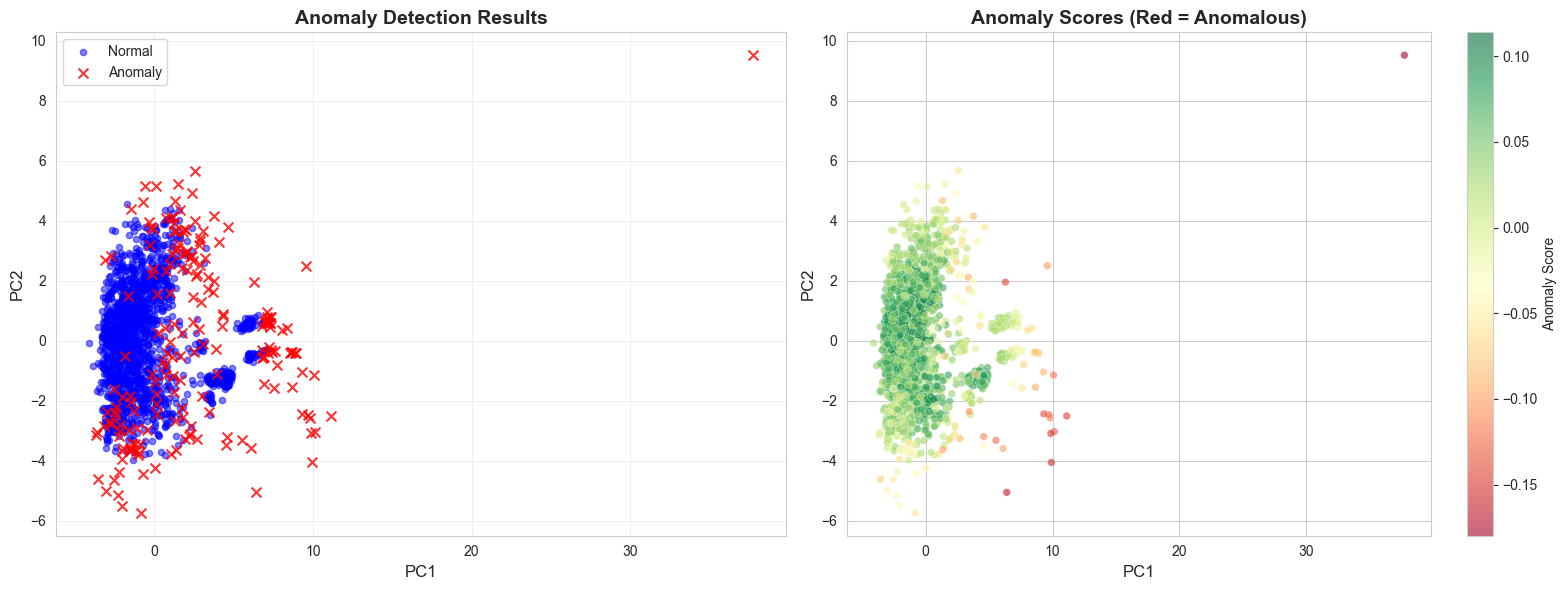

💡 Red X markers and red-colored points are detected anomalies


In [7]:
# Visualize anomalies in 2D
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Anomaly labels
colors = ['red' if x == -1 else 'blue' for x in anomaly_labels]
axes[0].scatter(X_2d[anomaly_labels == 1, 0], X_2d[anomaly_labels == 1, 1], 
               c='blue', alpha=0.5, s=20, label='Normal')
axes[0].scatter(X_2d[anomaly_labels == -1, 0], X_2d[anomaly_labels == -1, 1], 
               c='red', alpha=0.8, s=50, marker='x', label='Anomaly')
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)
axes[0].set_title('Anomaly Detection Results', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Anomaly scores
scatter = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=anomaly_scores, cmap='RdYlGn', 
                          alpha=0.6, s=30, edgecolors='white', linewidth=0.3)
axes[1].set_xlabel('PC1', fontsize=12)
axes[1].set_ylabel('PC2', fontsize=12)
axes[1].set_title('Anomaly Scores (Red = Anomalous)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=axes[1], label='Anomaly Score')

plt.tight_layout()
plt.show()

print("💡 Red X markers and red-colored points are detected anomalies")

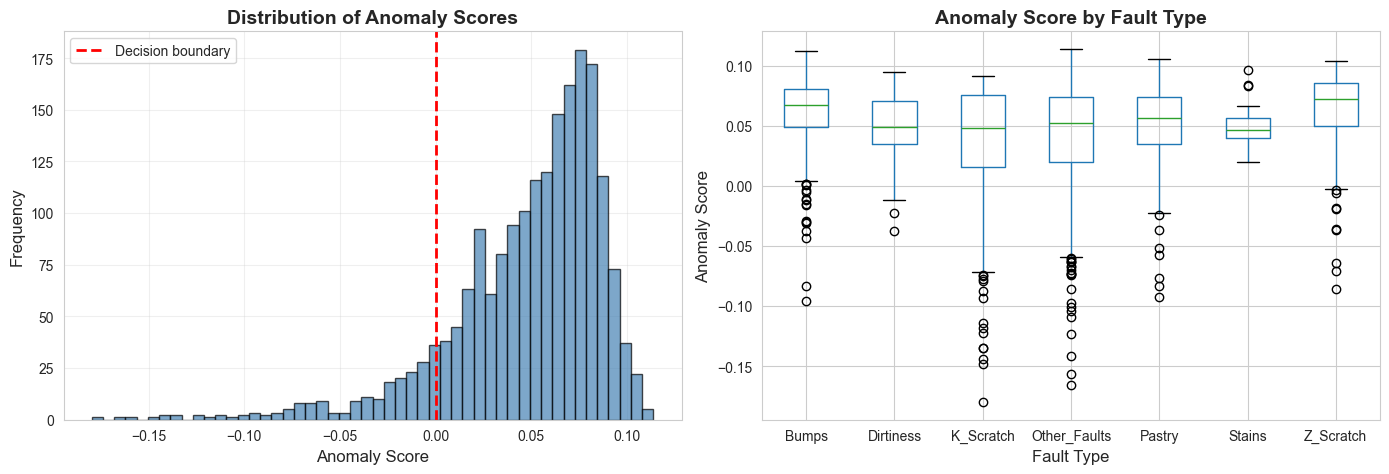

💡 Scores < 0 are classified as anomalies


In [8]:
# Distribution of anomaly scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(anomaly_scores, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Decision boundary')
axes[0].set_xlabel('Anomaly Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Anomaly Scores', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot by class
df.boxplot(column='Anomaly_Score', by='Class', ax=axes[1])
axes[1].set_xlabel('Fault Type', fontsize=12)
axes[1].set_ylabel('Anomaly Score', fontsize=12)
axes[1].set_title('Anomaly Score by Fault Type', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

print("💡 Scores < 0 are classified as anomalies")

In [9]:
# Show most anomalous samples
print("📋 Top 10 Most Anomalous Samples:\n")

# Get indices of most anomalous
most_anomalous_idx = np.argsort(anomaly_scores)[:10]

# Display
top_anomalies = df.iloc[most_anomalous_idx][['Class', 'Anomaly_Score', 'Pixels_Areas', 'X_Perimeter']].copy()
top_anomalies['Rank'] = range(1, 11)
top_anomalies = top_anomalies[['Rank', 'Class', 'Anomaly_Score', 'Pixels_Areas', 'X_Perimeter']]

print(top_anomalies.to_string(index=False))

print("\n💡 These samples deviate most from typical patterns")
print("   They may warrant further investigation")

📋 Top 10 Most Anomalous Samples:

 Rank        Class  Anomaly_Score  Pixels_Areas  X_Perimeter
    1    K_Scratch      -0.179848        152655        10449
    2 Other_Faults      -0.166057         11797          705
    3 Other_Faults      -0.156368         15775         1275
    4    K_Scratch      -0.148245         15208          861
    5    K_Scratch      -0.144465         20726         1193
    6 Other_Faults      -0.141515         19818          905
    7    K_Scratch      -0.134695         16469          929
    8    K_Scratch      -0.134607         14386          851
    9 Other_Faults      -0.123514         10166          593
   10    K_Scratch      -0.122941         16521          926

💡 These samples deviate most from typical patterns
   They may warrant further investigation


---
## 5. Summary

### 📊 Anomaly Detection Summary

| Metric | Value |
|--------|-------|
| Algorithm | Isolation Forest |
| Contamination | 10% |
| Anomalies Found | ~10% of data |
| Normal Samples | ~90% of data |

### 🎯 Key Findings

1. **Anomalies detected** across all fault types
2. **Some fault types** have higher anomaly rates
3. **Anomaly scores** help rank unusual samples
4. **Visual inspection** confirms reasonable detection

### 💡 Applications

- **Quality control**: Flag unusual defects for review
- **Data cleaning**: Identify potential data issues
- **Process monitoring**: Detect equipment problems

---

✅ **Phase 6 (Anomaly Detection) Complete!**

🎉 **All Data Mining phases are now complete!**